In [1]:
from os import listdir
from os.path import join, isdir, isfile
from neo.rawio import BlackrockRawIO
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
import math
from scipy import stats
import pickle
from datetime import datetime
from datetime import date as dte 
import pandas as pd
import seaborn as sns


In [2]:
class Data:
  def __init__(self, output_folder, load_processed=''):
    self.database = {}
    self.samplingFrequency = 1000
    self.NAc_signal = -400 #reference NAc signal: NAc response should be close to this value for the mouse to be considered usable
    self.output_folder = output_folder
    self.chanid_name = {0 : 'IL1', 1 : 'IL2', 2 : 'IL3', 3 : 'IL4', 4 : 'IL5',
     5 : 'IL6', 6 : 'IL7', 7 : 'IL8', 8 : 'NAc1', 9 : 'NAc2', 10 : 'NAc3', 11 : 'NAc4'}
    self.pre_window = 50 #ms before stim
    self.post_window = 50 #ms after stim
    if load_processed != '':
      print('Loading previously processed data')
      saved_pickle_dates = [datetime.strptime(p.rsplit('date_')[1].rsplit('.txt')[0], '%d_%m_%Y') for p in listdir(output_folder) if (isfile(join(output_folder, p)) and 'date' in p)]
      if load_processed == '0':
        selected_pickle = join(self.output_folder, 'date_' + max(saved_pickle_dates).strftime("%d_%m_%Y") + '.txt')
      else:
        selected_pickle = join(self.output_folder, 'date_' + load_processed + '.txt')
      try:
        filehandler = open(selected_pickle, 'rb') 
        prev_self = pickle.load(filehandler)
        self.database = prev_self.database
        self.samplingFrequency = prev_self.samplingFrequency
        self.output_folder = prev_self.output_folder
        self.chanid_name = prev_self.chanid_name
        self.pre_window = prev_self.pre_window
      except FileNotFoundError:
        print('No saved database found inthe directory you provided, loading everything')
    
    
  def load_all_mice_from_dir(self, base_dir):
    mice = [fol for fol in listdir(base_dir) if (isdir(join(base_dir, fol)) and 'Mouse' in fol)]
    for mouse in mice:
      self.add_mouse(base_dir, mouse.rsplit('Mouse')[1])


  def add_mouse(self, base_dir, mouseid):
    mousedir = join(base_dir, 'Mouse' + str(mouseid))
    dates = [fol for fol in listdir(mousedir) if isdir(join(mousedir, fol))]
    for date in dates:
      self.add_date_for_mouse(base_dir, mouseid, date)


  def add_date_for_mouse(self, base_dir, mouseid, date):
    #expect only one non-tuning ns2 file on a given date for a given mouse
    mousedate_dir = join(join(base_dir, 'Mouse' + str(mouseid)), date)
    file_on_date = [f.rsplit('.ns2')[0] for f in listdir(mousedate_dir) if (isfile(join(mousedate_dir, f)) and 'ns2' in f and 'tuning' not in f)][0]
    reader = BlackrockRawIO(filename=join(mousedate_dir, file_on_date), nsx_to_load = 2)
    reader.parse_header()
    # The data is in unit of 1/4 µV. This means that 100 in the NSx file equals to 25 µV. All values must be divided by 4.
    raw_sigs = np.array(reader.get_analogsignal_chunk(channel_indexes=None))/4
    notched_sigs = np.array([self.notch_filter(chan, 60) if i != 12 else chan for i, chan in enumerate(raw_sigs.T)]).T #remove 60 Hz noise
    filtered_sigs = np.array([self.butter_highpass_filter(chan, 15) if i != 12 else chan for i, chan in enumerate(notched_sigs.T)]).T
    # filtered_sigs = raw_sigs
    if mouseid not in self.database.keys():
      self.database[mouseid] = {date : {'mouseid' : mouseid, 'date' : date, 
      'filtered_sigs' : filtered_sigs, 'stimcalc' : self.calc_mouse(filtered_sigs, mouseid, date), 
      'plotted_all_regs' : False, 'plotted_all_wires' : False, 'plotted12' : False}}
      self.database[mouseid][date]['is_nac_ok'] = self.is_day_good(mouseid, date)
      chan_sorting, why_bad = self.find_good_bad_channels(mouseid, date)
      self.database[mouseid][date]['good_bad_channels'] = chan_sorting
      self.database[mouseid][date]['good_bad_channels_reason'] = why_bad
    else:
      if date not in self.database[mouseid].keys():
        print('Adding a record for Mouse' + str(mouseid) + ' on ' + str(date))
        self.database[mouseid][date] = {'mouseid' : mouseid, 'date' : date, 
        'filtered_sigs' : filtered_sigs, 'stimcalc' : self.calc_mouse(filtered_sigs, mouseid, date), 
        'plotted_all_regs' : False, 'plotted_all_wires' : False, 'plotted12' : False}
        self.database[mouseid][date]['is_nac_ok'] = self.is_day_good(mouseid, date)
        chan_sorting, why_bad = self.find_good_bad_channels(mouseid, date)
        self.database[mouseid][date]['good_bad_channels'] = chan_sorting
        self.database[mouseid][date]['good_bad_channels_reason'] = why_bad


  def overwrite_mouse_date(self, base_dir, mouseid, date):
    del self.database[mouseid][date]
    self.add_date_for_mouse(base_dir, mouseid, date)


  def delete_date(self, mouseid, date):
    del self.database[mouseid][date]


  def get_chan(self, mouseid, date, chanpos):
    return self.database[mouseid][date]['filtered_sigs'][:, chanpos]


  def get_stimcalc(self, mouseid, date):
    return self.database[mouseid][date]['stimcalc']


  def stim_wire_vector(self, mouseid, date, chanid):
    normalized_all_plotted = self.get_stimcalc(mouseid, date)
    means = []
    stds = []
    #0: channel, 1: stimulus, 2: time points
    for i in range(normalized_all_plotted.shape[2]):
      means.append(np.mean(normalized_all_plotted[chanid, :, i]))
      stds.append(np.std(normalized_all_plotted[chanid, :, i]))
    return [means, stds]


  def leaf_node_iterable(self):
    iterable = []
    mouseids = list(self.database.keys())
    mouseids.sort()
    for m in mouseids:
      dates = list(self.database[m].keys())
      dates.sort()
      for d in dates:
        iterable.append(self.database[m][d])
    return iterable


  def show_mice(self):
    print('Here is what we got:')
    mouseids = list(self.database.keys())
    mouseids.sort()
    for m in mouseids:
      print('Mouse' + str(m))
      dates = list(self.database[m].keys())
      dates.sort()
      for d in dates:
        if self.database[m][d]['is_nac_ok']:
          message = ' Usable'
        else:
          message = ' Not usable'
        print('\t ' + str(d) + message)
      print('\n')


  def laser_durations(self, filtered_sigs):
    laser = filtered_sigs[:, 12]
    laser_threshold = laser.copy() 
    laser_threshold[laser_threshold <= 500] = 0
    laser_threshold[laser_threshold > 0] = 1
    ld = []
    prev_val = 0
    start_stim = None
    stop_stim = None
    for i, val in enumerate(laser_threshold):
        if val == 1 and prev_val == 0:
            start_stim = i
            prev_val = 1
        elif val == 0 and prev_val == 1:
            stop_stim = i
            prev_val = 0
            ld.append([start_stim, stop_stim])
    # Add 1 ms at the tail end for off-by-one indexing used next
    adjusted_ld = [[t[0], t[1] + 1] for t in ld]
    return adjusted_ld


  def calc_mouse(self, filtered_sigs, mouseid, date):
    adjusted_ld = self.laser_durations(filtered_sigs)
    if len(adjusted_ld) == 0:
      raise ValueError('No stim windows found for mouse ' + mouseid + ' on ' + date) 
    stim_windows = []
    #From experience, stim intervals turn out to be 13-14ms long, so making all stim windows =14ms; due to off-by-one, make it 15
    for interval in adjusted_ld:
            duration = interval[1] - interval[0]
            if duration > 9 and duration < 16:
                stim_windows.append([interval[0], interval[0] + 15]) 
    #channels are il1, il2, il3, il4, il5, il6, il7, il8, nac1, nac2, nac3, nac4
    normalized_all_plotted = []
    for i in range(12):
      rc = filtered_sigs[:, i]
      normalized_plotted = []
      for interval in stim_windows:
          norm_factor = np.mean(rc[interval[0] - self.pre_window : interval[0]])
          normalized_plotted.append(rc[interval[0] - self.pre_window : interval[1]+self.post_window] - norm_factor)
      normalized_all_plotted.append(normalized_plotted)
    return np.array(normalized_all_plotted)


  def find_good_bad_channels(self, mouseid, date):
    channel_assignments = {i : True for i in range(12)}
    reason_bad = {}
    for chanid in range(12):
      #First, look at the noise in the signal: if pre-stimulus dominant frequency has peaks on average larger than 10, 
      #the channel is bad; alternatively, if signal portion has the lowest point not within 100 of -500uV,
      #it is also considered bad
      swv = self.stim_wire_vector(mouseid, date, chanid)[0]
      A = swv[:self.pre_window] #get 200 ms of signal just before stim
      A = A - np.mean(A)  # remove the DC part of the signal
      C = np.correlate(A, A, 'same')  # calculate autocorrelation to smooth out the noise
      P = signal.argrelextrema(C, np.greater)[0]  # caluclate local maxima (this step can be improved)
      P = P[C[P]>15000] # filter maxima, where the autocorrelation values is too low
      mean_resp = np.mean(np.array([np.abs(A[pos]) for pos in P]))
      if (chanid <= 7 and mean_resp > 10) or (chanid > 7 and (mean_resp > 25 or min(swv) > self.NAc_signal + 110 or min(swv) < self.NAc_signal - 110)):
        channel_assignments[chanid] = False
        if (chanid <= 7 and mean_resp > 10) or (chanid > 7 and mean_resp > 25):
          reason_bad[chanid] = 'High noise'
        elif chanid > 7 and min(swv) > self.NAc_signal + 110:
          reason_bad[chanid] = 'NAc response too low: ' + str(round(min(swv)))
        elif chanid > 7 and min(swv) < self.NAc_signal - 110:
          reason_bad[chanid] = 'NAc response too high: ' + str(round(min(swv)))
    return [channel_assignments, reason_bad]


  def butter_highpass(self, cutoff, order=5):
    normal_cutoff = cutoff/(self.samplingFrequency/2)
    # normal_cutoff = 2 * np.pi * cutoff
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=True)
    return b, a


  def butter_highpass_filter(self, data, cutoff, order=5):
    b, a = self.butter_highpass(cutoff, order=order)
    y = signal.filtfilt(b, a, data)
    return y


  def notch_filter(self, data, freq_to_yeet):
    quality_factor = 30
    b_notch, a_notch = signal.iirnotch(freq_to_yeet, quality_factor, self.samplingFrequency)
    return signal.filtfilt(b_notch, a_notch, data)


  def plot_all(self, replot = False):
    for element in self.leaf_node_iterable():
      mouseid = element['mouseid']
      date = element['date']
      if not self.database[mouseid][date]['plotted_all_regs'] or replot:
        self.plot_all_mouse_regions(mouseid, date)
      if not self.database[mouseid][date]['plotted_all_wires'] or replot:
        self.plot_all_mouse_wires(mouseid, date)
      if not self.database[mouseid][date]['plotted12'] or replot:
        self.subplot12(mouseid, date)


  def subplot12(self, mouseid, date):
    plt.rcParams['figure.figsize'] = (16, 8)
    normalized_all_plotted = self.get_stimcalc(mouseid, date)
    fig, axs = plt.subplots(3, 4)
    excluded = self.bad_chan_ids(mouseid, date)
    reason_bad = self.database[mouseid][date]['good_bad_channels_reason']
    for chanid in range(12):
      means = []
      stds = []
      point_outliers = []
      good_ones = []
      for j in range(normalized_all_plotted.shape[2]):
        q1 = np.quantile(normalized_all_plotted[chanid, :, j], 0.25)
        q3 = np.quantile(normalized_all_plotted[chanid, :, j], 0.75)
        IQR = q3 - q1
        point_outliers.append([1 if ((p < (q1 - 1.5 * IQR)) or (p > (q3 + 1.5 * IQR))) else 0 for p in normalized_all_plotted[chanid, :, j]])
      outlier_tribunal = np.sum(np.array(point_outliers), axis=0)
      for i, val in enumerate(outlier_tribunal):
        if val < 77:
          good_ones.append(i)
          axs[math.floor(chanid / 4), chanid % 4].plot(range(-data.pre_window, data.post_window+15), normalized_all_plotted[chanid, i, :], linewidth=3, alpha=0.3)
      for j in range(normalized_all_plotted.shape[2]):
        means.append(np.mean(normalized_all_plotted[chanid, good_ones, j]))
        stds.append(np.std(normalized_all_plotted[chanid, good_ones, :]))
      title = self.chanid_name[chanid] + ' response'
      if chanid in excluded:
        color = 'firebrick'
        axs[math.floor(chanid / 4), chanid % 4].text(0.5, 0.1, reason_bad[chanid], 
        horizontalalignment='center', 
        verticalalignment='bottom', fontsize=11,
        transform = axs[math.floor(chanid / 4), chanid % 4].transAxes)
      else:
        color = 'dodgerblue'
      axs[math.floor(chanid / 4), chanid % 4].plot(range(-self.pre_window, self.post_window+15), means, linewidth=3, color=color)
      lower_std = [means[i] - stds[i] for i in range(len(means))]
      upper_std = [means[i] + stds[i] for i in range(len(means))]
      axs[math.floor(chanid / 4), chanid % 4].set_title(title)
      axs[math.floor(chanid / 4), chanid % 4].text(0.5, 0.1, 'n=' + str(len(good_ones)), 
        horizontalalignment='right', 
        verticalalignment='top', fontsize=11,
        transform = axs[math.floor(chanid / 4), chanid % 4].transAxes)
      # axs[math.floor(chanid / 4), chanid % 4].fill_between(range(-self.pre_window, self.post_window+15), lower_std, upper_std, alpha=.1, color=color)
      axs[math.floor(chanid / 4), chanid % 4].axvspan(0, 14, alpha=0.3, color='blue')
      axs[math.floor(chanid / 4), chanid % 4].axhspan(-0.1, 0.1, color='black')
      axs[math.floor(chanid / 4), chanid % 4].set_ylabel('Normalized Potential [uV]', fontsize=10)
      axs[math.floor(chanid / 4), chanid % 4].set_xlabel('Time [msec]', fontsize=10)
    d = Path(join(join(self.output_folder, 'Mouse' + mouseid), date))
    try:
      Path.mkdir(d, parents=True)
    except FileExistsError:
      pass
    title_main = 'All responses in Mouse' + mouseid + ' on ' + date
    plt.tight_layout()
    fig.subplots_adjust(top=0.8)
    fig.suptitle('Responses in Mouse' + mouseid + ' on ' + date, y=0.98)
    plt.savefig(join(d, title_main + ".pdf"), format='pdf', bbox_inches='tight', transparent=True)
    plt.clf()
    plt.cla()
    plt.close('all')
    self.database[mouseid][date]['plotted12'] = True


  def plot_all_mouse_regions(self, mouseid, date):
    self.plot_mouse_region(mouseid, date, 'IL')
    self.plot_mouse_region(mouseid, date, 'NAc')
    self.database[mouseid][date]['plotted_all_regs'] = True


  def plot_all_mouse_wires(self, mouseid, date):
    for chanid in range(12):
      self.plot_wire(mouseid, date, chanid)
    self.database[mouseid][date]['plotted_all_wires'] = True


  def is_day_good(self, mouseid, date):
    min_nac = self.min_NAc_val(mouseid, date)
    if min_nac < self.NAc_signal + 110 and min_nac > self.NAc_signal - 110:
      return True
    else:
      return False


  def min_NAc_val(self, mouseid, date):
    normalized_all_plotted = self.get_stimcalc(mouseid, date)
    min_vals = []
    for i in range(8, 12):
      means = []
      for j in range(normalized_all_plotted.shape[2]):
        selection = normalized_all_plotted[i, :, j]
        means.append(np.mean(selection))
      min_vals.append(min(means))
    return min(min_vals)


  def bad_chan_ids(self, mouseid, date):
    chan_assessment = self.database[mouseid][date]['good_bad_channels']
    return [i for i in chan_assessment.keys() if not chan_assessment[i]]


  def plot_mouse_region(self, mouseid, date, region):
    if region == 'IL':
      w = range(0, 7)
    else:
      w = range(8, 12)
    excluded = self.bad_chan_ids(mouseid, date)
    w = [True if x in w and x not in excluded else False for x in range(12)]
    #0: channel, 1: stimulus, 2: time points
    normalized_all_plotted = self.get_stimcalc(mouseid, date)
    means = []
    stds = []
    for i in range(normalized_all_plotted.shape[2]):
      selection = normalized_all_plotted[w, :, i]
      means.append(np.mean(selection))
      stds.append(np.std(selection))
    title = region + ' response in Mouse' + mouseid + ' on ' + date
    self.main_plotter(mouseid, date, means, stds, title)  
    plt.clf()
    plt.cla()
    plt.close('all')


  def plot_wire(self, mouseid, date, chanid):
    #0: channel, 1: stimulus, 2: time points
    normalized_all_plotted = self.get_stimcalc(mouseid, date)
    means = []
    stds = []
    for i in range(normalized_all_plotted.shape[2]):
      means.append(np.mean(normalized_all_plotted[chanid, :, i]))
      stds.append(np.std(normalized_all_plotted[chanid, :, i]))
    title = self.chanid_name[chanid] + ' response in Mouse' + mouseid + ' on ' + date
    self.main_plotter(mouseid, date, means, stds, title) 
    plt.clf()
    plt.cla()
    plt.close('all')


  def main_plotter(self, mouseid, date, means, stds, title):
    # Time from -self.pre_window ms before stim to self.post_window + 15 ms after stim
    plt.plot(range(-self.pre_window, self.post_window+15), means, linewidth=3)
    lower_std = [means[i] - stds[i] for i in range(len(means))]
    upper_std = [means[i] + stds[i] for i in range(len(means))]
    plt.title(title)
    plt.rcParams['figure.figsize'] = (16, 8)
    # plt.fill_between(range(-self.pre_window, self.post_window+15), lower_std, upper_std, alpha=.1)
    plt.axvspan(0, 14, alpha=0.3, color='blue')
    plt.ylabel('Normalized Potential [uV]', fontsize=15)
    plt.xlabel('Time [msec]', fontsize=15)
    d = Path(join(join(self.output_folder, 'Mouse' + mouseid), date))
    try:
      Path.mkdir(d, parents=True)
    except FileExistsError:
      pass
    plt.savefig(join(d, title + ".pdf"), format='pdf', bbox_inches='tight', transparent=True)
    plt.clf()
    plt.cla()
    plt.close('all')


  def save(self):
    file = open(join(self.output_folder, 'date_' + dte.today().strftime("%d_%m_%Y") + '.txt'), 'wb')
    pickle.dump(self, file)
    file.close()


In [3]:
base_dir = '/Users/kirill/Desktop/lab/OptoLinCx/'
sheet_id = "1H0kOaD_8cs5AYVkZ3PigRFJxXZMTYSo9gS9fBwVQwNo"
sheet_name = "usability"
disambig_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

#in the two first cohorts, two mice had left and right IL channels swapped
# swapped_IL = ['55412', '55422']

data = Data(join(base_dir, 'out'), load_processed='0') #load from previous save
# data.delete_date('04102', '070622')
# data = Data(join(base_dir, 'out')) #re-run the whole thing

# data.load_all_mice_from_dir(base_dir)
# data.plot_all()
# data.save()

Loading previously processed data


In [73]:
def best_response(data, mouseid, date, chanid):
  normalized_all_plotted = data.get_stimcalc(mouseid, date)
  means = []
  point_outliers = []
  good_ones = []
  for j in range(normalized_all_plotted.shape[2]):
    q1 = np.quantile(normalized_all_plotted[chanid, :, j], 0.25)
    q3 = np.quantile(normalized_all_plotted[chanid, :, j], 0.75)
    IQR = q3 - q1
    point_outliers.append([1 if ((p < (q1 - 1.5 * IQR)) or (p > (q3 + 1.5 * IQR))) else 0 for p in normalized_all_plotted[chanid, :, j]])
  outlier_tribunal = np.sum(np.array(point_outliers), axis=0)
  for i, val in enumerate(outlier_tribunal):
    if val < 77:
      good_ones.append(i)
  for j in range(normalized_all_plotted.shape[2]):
    selection = normalized_all_plotted[chanid, good_ones, j]
    means.append(np.mean(selection))
  select_window = means[data.pre_window:data.pre_window+10]
  return [min(select_window), max(select_window)]


def min_max_response_for_channels(data, mouseid, date, channellist, functional_chans):
  best_region_this_day_wire_id = None
  best_this_region_this_day_min = None
  best_this_region_this_day_max = None
  for chanid in channellist:
    if chanid in functional_chans:
      minval, maxval = best_response(data, mouseid, date, chanid)
      if best_this_region_this_day_min is None or minval < best_this_region_this_day_min:
        best_region_this_day_wire_id = chanid
        best_this_region_this_day_min = minval
      if best_this_region_this_day_max is None or maxval > best_this_region_this_day_max:
        best_this_region_this_day_max = maxval
  return [best_region_this_day_wire_id, best_this_region_this_day_min, best_this_region_this_day_max]
  

def build_analysis_df(data, disambig_url):
      columnames = ['mouseid', 'date', 'group', 'recording_session', 'functional_chans',
      'best_this_day_left_IL_wire_id', 'best_this_day_right_IL_wire_id', 'best_this_day_NAc_wire_id', 
      'best_this_day_left_IL_min', 'best_this_day_left_IL_max', 'best_this_day_right_IL_min', 'best_this_day_right_IL_max', 'best_this_day_NAc_min']
      masterframe = pd.DataFrame(columns = columnames)
      usability_df = pd.read_csv(disambig_url)
      region_to_range = {'left_IL' : range(0, 4), 'right_IL' : range(4, 8), 'NAc' : range(8, 12)}
      for element in usability_df.iterrows():
        element = element[1]
        for recording_session in ['Day 0', 'Day 1', 'Day 2']:
          histo_good = element['Histology good']
          # if not histo_good:
          #   continue
          df = pd.DataFrame(columns = columnames)
          mouseid = str(element['Mouse'])
          if len(mouseid) == 4:
            mouseid = '0' + mouseid
          df['mouseid'] = [mouseid]
          date = str(element[recording_session]).strip('.0')
          print('Looking at mouse' + mouseid + ' on ' + recording_session)
          if len(date) == 5:
            date = '0' + date
          if date == 'nan':
            print('Skipping mouse ' + mouseid + ' on ' + recording_session + ' because there is no recording on this date')
            continue
          try:
            data.get_chan(mouseid, date, 0)
          except KeyError:
            print('No data for mouse ' + mouseid + ' on ' + date)
            continue
          mousedata = data.database[mouseid][date]
          functional_chans = [i for i in mousedata['good_bad_channels'].keys() if mousedata['good_bad_channels'][i]]
          if not data.is_day_good(mouseid, date) or not any(i in functional_chans for i in range(8)):
            if not data.is_day_good(mouseid, date):
              print('Skipping mouse ' + mouseid + ' on ' + recording_session + ' because it has no good NAc responses on this day')
            else:
              print('Skipping mouse ' + mouseid + ' on ' + recording_session + ' because it has no good IL responses on this day')
            continue
          df['date'] = [date]
          best_this_day_left_IL_wire_id, best_this_day_left_IL_min, best_this_day_left_IL_max = min_max_response_for_channels(data, mouseid, date, region_to_range['left_IL'], functional_chans)
          best_this_day_right_IL_wire_id, best_this_day_right_IL_min, best_this_day_right_IL_max = min_max_response_for_channels(data, mouseid, date, region_to_range['right_IL'], functional_chans)
          best_this_day_NAc_wire_id, best_this_day_NAc_min, _ = min_max_response_for_channels(data, mouseid, date, region_to_range['NAc'], functional_chans)
          df['best_this_day_left_IL_wire_id'] = [best_this_day_left_IL_wire_id]
          df['best_this_day_left_IL_min'] = [best_this_day_left_IL_min]
          df['best_this_day_left_IL_max'] = [best_this_day_left_IL_max]
          df['best_this_day_right_IL_wire_id'] = [best_this_day_right_IL_wire_id]
          df['best_this_day_right_IL_min'] = [best_this_day_right_IL_min]
          df['best_this_day_right_IL_max'] = [best_this_day_right_IL_max]
          df['best_this_day_NAc_wire_id'] = [best_this_day_NAc_wire_id]
          df['best_this_day_NAc_min'] = [best_this_day_NAc_min]
          df['group'] = [element['Group']]
          df['recording_session'] = [recording_session]
          df['functional_chans'] = [functional_chans]
          frames = [masterframe, df]
          masterframe = pd.concat(frames)
      masterframe['best_this_day_left_min_IL_NAc_normalized'] = masterframe['best_this_day_left_IL_min']/masterframe['best_this_day_NAc_min'] 
      masterframe['best_this_day_right_min_IL_NAc_normalized'] = masterframe['best_this_day_right_IL_min']/masterframe['best_this_day_NAc_min'] 
      masterframe['best_this_day_left_max_IL_NAc_normalized'] = masterframe['best_this_day_left_IL_max']/masterframe['best_this_day_NAc_min'] 
      masterframe['best_this_day_right_max_IL_NAc_normalized'] = masterframe['best_this_day_right_IL_max']/masterframe['best_this_day_NAc_min'] 
      return masterframe


sheet_url = "https://docs.google.com/spreadsheets/d/1H0kOaD_8cs5AYVkZ3PigRFJxXZMTYSo9gS9fBwVQwNo/edit#gid=1524970843"
disambig_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
masterframe = build_analysis_df(data, disambig_url)
masterframe = masterframe.sort_values(by=['mouseid'])
masterframe.to_csv(join(base_dir, 'out/analysis.csv'))



Looking at mouse55411 on Day 0
Skipping mouse 55411 on Day 0 because there is no recording on this date
Looking at mouse55411 on Day 1
No data for mouse 55411 on 030922
Looking at mouse55411 on Day 2
Skipping mouse 55411 on Day 2 because there is no recording on this date
Looking at mouse55412 on Day 0
Skipping mouse 55412 on Day 0 because there is no recording on this date
Looking at mouse55412 on Day 1
No data for mouse 55412 on 030922
Looking at mouse55412 on Day 2
No data for mouse 55412 on 040722
Looking at mouse55413 on Day 0
Skipping mouse 55413 on Day 0 because there is no recording on this date
Looking at mouse55413 on Day 1
No data for mouse 55413 on 030922
Looking at mouse55413 on Day 2
No data for mouse 55413 on 040722
Looking at mouse55414 on Day 0
Skipping mouse 55414 on Day 0 because there is no recording on this date
Looking at mouse55414 on Day 1
No data for mouse 55414 on 030922
Looking at mouse55414 on Day 2
No data for mouse 55414 on 040722
Looking at mouse55415 on 

In [53]:
d = pd.read_csv(disambig_url)
rows = [i for i in d.iterrows()]
rows[33][1]['Histology good']


False

In [74]:
def build_cross_day_df(analysis_df, data):
  columnames = ['mouseid', 'group', 'df/f_12_left', 'NAc_normalized_df/f_12_left', 'df/f_12_right', 'NAc_normalized_df/f_12_right',
      'df/f_01_left', 'NAc_normalized_df/f_01_left', 'df/f_01_right', 'NAc_normalized_df/f_01_right',
      'df/f_02_left', 'NAc_normalized_df/f_02_left', 'df/f_02_right', 'NAc_normalized_df/f_02_right',
      'best_day2_left_IL_wire_id', 'best_day2_right_IL_wire_id', 'best_day2_NAc_wire_id', 
      'best_day2_left_IL_min_d0', 'best_day02_left_IL_max_d0', 'best_day2_right_IL_min_d0', 'best_day2_right_IL_max_d0', 'best_day2_NAc_min_d0',
      'best_day2_left_IL_min_d1', 'best_day02_left_IL_max_d1', 'best_day2_right_IL_min_d1', 'best_day2_right_IL_max_d1', 'best_day2_NAc_min_d1',
      'best_day2_left_IL_min_d2', 'best_day02_left_IL_max_d2', 'best_day2_right_IL_min_d2', 'best_day2_right_IL_max_d2', 'best_day2_NAc_min_d2',
      'best_day2_left_IL_NAc_normalized_d2', 'best_day2_left_IL_NAc_normalized_d1', 'best_day2_left_IL_NAc_normalized_d0',
      'best_day2_right_IL_NAc_normalized_d2', 'best_day2_right_IL_NAc_normalized_d1', 'best_day2_right_IL_NAc_normalized_d0']
  masterframe = pd.DataFrame(columns = columnames)
  for m in analysis_df['mouseid'].unique():
    df = pd.DataFrame(columns = columnames)
    df_slice = analysis_df.loc[analysis_df['mouseid'] == m]
    df_d0_row = df_slice.loc[df_slice['recording_session'] == 'Day 0']
    df_d1_row = df_slice.loc[df_slice['recording_session'] == 'Day 1']
    df_d2_row = df_slice.loc[df_slice['recording_session'] == 'Day 2']
    date_d0_pre = list(df_slice.loc[df_slice['recording_session'] == 'Day 0']['date'])
    if len(date_d0_pre) > 0:
      date_d0 = date_d0_pre[0]
      day0_functional = list(df_d0_row['functional_chans'])[0]
    else:
      date_d0 = None
      day0_functional = []
    date_d1_pre = list(df_slice.loc[df_slice['recording_session'] == 'Day 1']['date'])
    if len(date_d1_pre) > 0:
      date_d1 = date_d1_pre[0]
      day1_functional = list(df_d1_row['functional_chans'])[0]
    else:
      date_d1 = None
      day1_functional = []
    date_d2_pre = list(df_slice.loc[df_slice['recording_session'] == 'Day 2']['date'])
    if len(date_d2_pre) > 0:
      date_d2 = date_d2_pre[0]
      day2_functional = list(df_d2_row['functional_chans'])[0]
    else:
      date_d2 = None
      day2_functional = []
    if len(day2_functional) != 0 and len(day1_functional) != 0:
      functional_overlap = [i for i in day1_functional if i in day2_functional]
      left_IL_overlap = [i for i in range(4) if i in functional_overlap]
      right_IL_overlap = [i for i in range(4, 8) if i in functional_overlap]
      NAc_overlap = [i for i in range(8, 12) if i in functional_overlap]
      if any(left_IL_overlap):
        df['mouseid'] = [m]
        df['group'] = [list(df_slice['group'])[0]]
        best_day2_left_IL_wire_id, best_day2_left_IL_min_d2, best_day02_left_IL_max_d2 = min_max_response_for_channels(data, m, date_d2, left_IL_overlap, day2_functional)
        best_day2_NAc_wire_id, best_day2_NAc_min_d2, _ = min_max_response_for_channels(data, m, date_d2, NAc_overlap, day2_functional)
        #Only look at response on day 1 for the wires that overlap with day 2 and are best on day 2:
        _, best_day2_left_IL_min_d1, best_day02_left_IL_max_d1 = min_max_response_for_channels(data, m, date_d1, [best_day2_left_IL_wire_id], day1_functional)
        _, best_day2_NAc_min_d1, _ = min_max_response_for_channels(data, m, date_d1, [best_day2_NAc_wire_id], day1_functional)
        df['best_day2_left_IL_wire_id'] = [best_day2_left_IL_wire_id]
        df['best_day2_left_IL_min_d2'] = [best_day2_left_IL_min_d2]
        df['best_day02_left_IL_max_d2'] = [best_day02_left_IL_max_d2]
        df['best_day2_NAc_wire_id'] = [best_day2_NAc_wire_id]
        df['best_day2_NAc_min_d2'] = [best_day2_NAc_min_d2]
        df['best_day2_left_IL_min_d1'] = [best_day2_left_IL_min_d1]
        df['best_day02_left_IL_max_d1'] = [best_day02_left_IL_max_d1]
        df['best_day2_NAc_min_d1'] = [best_day2_NAc_min_d1]
        try:
          dff = (best_day2_left_IL_min_d2 - best_day2_left_IL_min_d1)/best_day2_left_IL_min_d1
        except TypeError:
          dff = None
        df['df/f_12_left'] = [dff]
        NAc_normalized_df = (best_day2_left_IL_min_d2/best_day2_NAc_min_d2 - best_day2_left_IL_min_d1/best_day2_NAc_min_d1)/(best_day2_left_IL_min_d1/best_day2_NAc_min_d1)
        df['NAc_normalized_df/f_12_left'] = [NAc_normalized_df]
        df['best_day2_left_IL_NAc_normalized_d2'] = best_day2_left_IL_min_d2/best_day2_NAc_min_d2
        df['best_day2_left_IL_NAc_normalized_d1'] = best_day2_left_IL_min_d1/best_day2_NAc_min_d1
        if any(right_IL_overlap):
          best_day2_right_IL_wire_id, best_day2_right_IL_min_d2, best_day02_right_IL_max_d2 = min_max_response_for_channels(data, m, date_d2, right_IL_overlap, day2_functional)
          #Only look at response on day 1 for the wires that overlap with day 2 and are best on day 2:
          _, best_day2_right_IL_min_d1, best_day02_right_IL_max_d1 = min_max_response_for_channels(data, m, date_d1, [best_day2_right_IL_wire_id], day1_functional)
          df['best_day2_right_IL_wire_id'] = [best_day2_right_IL_wire_id]
          df['best_day2_right_IL_min_d2'] = [best_day2_right_IL_min_d2]
          df['best_day02_right_IL_max_d2'] = [best_day02_right_IL_max_d2]
          df['best_day2_right_IL_min_d1'] = [best_day2_right_IL_min_d1]
          df['best_day02_right_IL_max_d1'] = [best_day02_right_IL_max_d1]
          try:
            dff = (best_day2_right_IL_min_d2 - best_day2_right_IL_min_d1)/best_day2_right_IL_min_d1
          except TypeError:
            dff = None
          df['df/f_12_right'] = [dff]
          try:
            NAc_normalized_df = (best_day2_right_IL_min_d2/best_day2_NAc_min_d2 - best_day2_right_IL_min_d1/best_day2_NAc_min_d1)/(best_day2_right_IL_min_d1/best_day2_NAc_min_d1)
          except TypeError:
            NAc_normalized_df = None
          df['NAc_normalized_df/f_12_right'] = [NAc_normalized_df]
          try:
            df['best_day2_right_IL_NAc_normalized_d2'] = best_day2_right_IL_min_d2/best_day2_NAc_min_d2
          except TypeError:
            df['best_day2_right_IL_NAc_normalized_d2'] = None
          try:
            df['best_day2_right_IL_NAc_normalized_d1'] = best_day2_right_IL_min_d1/best_day2_NAc_min_d1
          except TypeError:
            df['best_day2_right_IL_NAc_normalized_d1'] = None
    if len(day1_functional) != 0 and len(day0_functional) != 0 and len(day2_functional) != 0:
      functional_overlap_a = [i for i in day0_functional if i in day1_functional]
      functional_overlap = [i for i in functional_overlap_a if i in day2_functional]
      left_IL_overlap = [i for i in range(4) if i in functional_overlap]
      right_IL_overlap = [i for i in range(4, 8) if i in functional_overlap]
      NAc_overlap = [i for i in range(8, 12) if i in functional_overlap]
      if any(left_IL_overlap):
        _, best_day2_left_IL_min_d0, best_day02_left_IL_max_d0 = min_max_response_for_channels(data, m, date_d0, [best_day2_left_IL_wire_id], day0_functional)
        _, best_day2_NAc_min_d0, _ = min_max_response_for_channels(data, m, date_d0, [best_day2_NAc_wire_id], day0_functional)
        df['best_day2_left_IL_min_d0'] = [best_day2_left_IL_min_d0]
        df['best_day02_left_IL_max_d0'] = [best_day02_left_IL_max_d0]
        df['best_day2_NAc_min_d0'] = [best_day2_NAc_min_d0]
        try:
          dff = (best_day2_left_IL_min_d1 - best_day2_left_IL_min_d0)/best_day2_left_IL_min_d0
        except TypeError:
          dff = None
        df['df/f_01_left'] = [dff]
        try:
          NAc_normalized_df = (best_day2_left_IL_min_d1/best_day2_NAc_min_d1 - best_day2_left_IL_min_d0/best_day2_NAc_min_d0)/(best_day2_left_IL_min_d0/best_day2_NAc_min_d0)
        except TypeError:
          NAc_normalized_df = None
        df['NAc_normalized_df/f_01_left'] = [NAc_normalized_df]
        try:
          df['best_day2_left_IL_NAc_normalized_d0'] = best_day2_left_IL_min_d0/best_day2_NAc_min_d0
        except TypeError:
          df['best_day2_left_IL_NAc_normalized_d0'] = None
        if any(right_IL_overlap):
          _, best_day2_right_IL_min_d0, best_day02_right_IL_max_d0 = min_max_response_for_channels(data, m, date_d0, [best_day2_right_IL_wire_id], day0_functional)
          df['best_day2_right_IL_min_d0'] = [best_day2_right_IL_min_d0]
          df['best_day02_right_IL_max_d0'] = [best_day02_right_IL_max_d0]
          try:
            dff = (best_day2_right_IL_min_d1 - best_day2_right_IL_min_d0)/best_day2_right_IL_min_d0
          except TypeError:
            dff = None
          df['df/f_01_right'] = [dff]
          try:
            NAc_normalized_df = (best_day2_right_IL_min_d1/best_day2_NAc_min_d1 - best_day2_right_IL_min_d0/best_day2_NAc_min_d0)/(best_day2_right_IL_min_d0/best_day2_NAc_min_d0)
          except TypeError:
            NAc_normalized_df = None
          df['NAc_normalized_df/f_01_right'] = [NAc_normalized_df]
          try:
            df['best_day2_right_IL_NAc_normalized_d0'] = best_day2_right_IL_min_d0/best_day2_NAc_min_d0
          except TypeError:
            df['best_day2_right_IL_NAc_normalized_d0'] = None
    if len(day2_functional) != 0 and len(day0_functional) != 0:
      functional_overlap = [i for i in day0_functional if i in day2_functional]
      left_IL_overlap = [i for i in range(4) if i in functional_overlap]
      right_IL_overlap = [i for i in range(4, 8) if i in functional_overlap]
      NAc_overlap = [i for i in range(8, 12) if i in functional_overlap]
      if any(left_IL_overlap):
        try:
          dff = (best_day2_left_IL_min_d2 - best_day2_left_IL_min_d0)/best_day2_left_IL_min_d0
        except TypeError:
          dff = None
        df['df/f_02_left'] = [dff]
        try:
          NAc_normalized_df = (best_day2_left_IL_min_d2/best_day2_NAc_min_d2 - best_day2_left_IL_min_d0/best_day2_NAc_min_d0)/(best_day2_left_IL_min_d0/best_day2_NAc_min_d0)
        except TypeError:
          NAc_normalized_df = None
        df['NAc_normalized_df/f_02_left'] = [NAc_normalized_df]
        if any(right_IL_overlap):
          try:
            dff = (best_day2_right_IL_min_d2 - best_day2_right_IL_min_d0)/best_day2_right_IL_min_d0
          except TypeError:
            dff = None
          df['df/f_02_right'] = [dff]
          try:
            NAc_normalized_df = (best_day2_right_IL_min_d2/best_day2_NAc_min_d2 - best_day2_right_IL_min_d0/best_day2_NAc_min_d0)/(best_day2_right_IL_min_d0/best_day2_NAc_min_d0)
          except TypeError:
            NAc_normalized_df = None
          df['NAc_normalized_df/f_02_right'] = [NAc_normalized_df]
    frames = [masterframe, df]
    masterframe = pd.concat(frames)
  return masterframe


cross_day_masterframe = build_cross_day_df(masterframe, data)
cross_day_masterframe.to_csv(join(base_dir, 'out/cross_day_analysis.csv'))

cross_day_masterframe.head(50)

,mouseid,group,df/f_12_left,NAc_normalized_df/f_12_left,df/f_12_right,NAc_normalized_df/f_12_right,df/f_01_left,NAc_normalized_df/f_01_left,df/f_01_right,NAc_normalized_df/f_01_right,...,best_day2_NAc_min_d2,best_day2_left_IL_NAc_normalized_d2,best_day2_left_IL_NAc_normalized_d1,best_day2_left_IL_NAc_normalized_d0,best_day2_right_IL_NAc_normalized_d2,best_day2_right_IL_NAc_normalized_d1,best_day2_right_IL_NAc_normalized_d0,best_day02_right_IL_max_d2,best_day02_right_IL_max_d1,best_day02_right_IL_max_d0
0,04092,A,-0.032967,-0.133391,-0.211953,-0.293790,NaN,NaN,NaN,NaN,...,-360.339441,0.041639,0.048048,NaN,0.028417,0.040239,NaN,0.057796,-0.859247,NaN
0,04093,B,3.489991,2.471241,0.205047,-0.068371,-0.127397,0.010516,-0.154746,-0.021156,...,-426.656260,0.268920,0.077471,0.076665,0.045983,0.049357,0.050424,1.204880,-2.451345,-0.134062
0,04094,F,0.835913,0.537402,1.340741,0.960147,-0.650118,-0.546591,-0.672561,-0.575674,...,-356.775104,0.024099,0.015675,0.034571,0.023702,0.012092,0.028497,2.718243,1.380434,-1.452716
0,04095,F,-0.558478,-0.573399,-0.746986,-0.755537,-0.785659,-0.770548,-0.272264,-0.22096,...,-326.370905,0.006551,0.015356,0.066927,0.009589,0.039225,0.05035,1.629447,-4.862046,-1.532430
0,04101,A,26.300685,24.066647,18.087681,16.525720,-0.796325,-0.767923,-0.652239,-0.603745,...,-328.048491,0.099536,0.003971,0.01711,0.081219,0.004634,0.011695,-0.362314,0.764434,0.992923
0,04102,B,2.572319,1.466391,6.385006,4.098736,-0.526931,-0.486713,-0.63385,-0.602721,...,-485.223187,0.077613,0.031468,0.061308,0.066226,0.012989,0.032694,-10.286967,1.759869,-2.113932
0,04104,F,0.556085,0.293189,0.235986,0.027169,4.610544,None,-0.089032,None,...,-338.457304,0.011340,0.008769,None,0.012878,0.012538,None,0.308196,-0.370894,1.737501
0,04105,F,0.400979,0.322940,0.516519,0.432044,-0.264632,-0.176853,-0.394089,-0.321762,...,-335.738528,0.090070,0.068083,0.082711,0.063368,0.044250,0.065243,2.148251,-1.470654,-4.243568
0,04112,B,0.069213,0.060895,-0.042636,-0.050084,-0.119594,-0.167345,0.71835,0.625151,...,-400.104405,0.057281,0.053993,0.064844,0.033400,0.035161,0.021636,0.755633,-0.349428,4.781652
0,04113,B,0.870373,0.778782,1.329739,1.215652,-0.401715,-0.365394,-0.61967,-0.596581,...,-356.282836,0.019715,0.011083,0.017465,0.017640,0.007962,0.019735,1.173637,0.748156,-2.614057


In [ ]:
# ['Bad NAc response on day 1', 12], ['Died unexplainably b/w first and second recording', 5], 
# ['Died during/soon after surgery', 3], ['lost ferrule by day 2', 2], 
# ['Lost signal by day 2 in key region', 2], ['Ferrule interferes with omnetics', 1],
# ['NAc response too weak even at very high laser power', 3], ['None', 3]

In [83]:

cross_day_masterframe.head(50)

,mouseid,group,df/f_12_left,NAc_normalized_df/f_12_left,df/f_12_right,NAc_normalized_df/f_12_right,df/f_01_left,NAc_normalized_df/f_01_left,df/f_01_right,NAc_normalized_df/f_01_right,...,best_day2_NAc_min_d2,best_day2_left_IL_NAc_normalized_d2,best_day2_left_IL_NAc_normalized_d1,best_day2_left_IL_NAc_normalized_d0,best_day2_right_IL_NAc_normalized_d2,best_day2_right_IL_NAc_normalized_d1,best_day2_right_IL_NAc_normalized_d0,best_day02_right_IL_max_d2,best_day02_right_IL_max_d1,best_day02_right_IL_max_d0
0,04092,A,-0.032967,-0.133391,-0.211953,-0.293790,NaN,NaN,NaN,NaN,...,-360.339441,0.041639,0.048048,NaN,0.028417,0.040239,NaN,0.057796,-0.859247,NaN
0,04093,B,3.489991,2.471241,0.205047,-0.068371,-0.127397,0.010516,-0.154746,-0.021156,...,-426.656260,0.268920,0.077471,0.076665,0.045983,0.049357,0.050424,1.204880,-2.451345,-0.134062
0,04094,F,0.835913,0.537402,1.340741,0.960147,-0.650118,-0.546591,-0.672561,-0.575674,...,-356.775104,0.024099,0.015675,0.034571,0.023702,0.012092,0.028497,2.718243,1.380434,-1.452716
0,04095,F,-0.558478,-0.573399,-0.746986,-0.755537,-0.785659,-0.770548,-0.272264,-0.22096,...,-326.370905,0.006551,0.015356,0.066927,0.009589,0.039225,0.05035,1.629447,-4.862046,-1.532430
0,04101,A,26.300685,24.066647,18.087681,16.525720,-0.796325,-0.767923,-0.652239,-0.603745,...,-328.048491,0.099536,0.003971,0.01711,0.081219,0.004634,0.011695,-0.362314,0.764434,0.992923
0,04102,B,2.572319,1.466391,6.385006,4.098736,-0.526931,-0.486713,-0.63385,-0.602721,...,-485.223187,0.077613,0.031468,0.061308,0.066226,0.012989,0.032694,-10.286967,1.759869,-2.113932
0,04104,F,0.556085,0.293189,0.235986,0.027169,4.610544,None,-0.089032,None,...,-338.457304,0.011340,0.008769,None,0.012878,0.012538,None,0.308196,-0.370894,1.737501
0,04105,F,0.400979,0.322940,0.516519,0.432044,-0.264632,-0.176853,-0.394089,-0.321762,...,-335.738528,0.090070,0.068083,0.082711,0.063368,0.044250,0.065243,2.148251,-1.470654,-4.243568
0,04112,B,0.069213,0.060895,-0.042636,-0.050084,-0.119594,-0.167345,0.71835,0.625151,...,-400.104405,0.057281,0.053993,0.064844,0.033400,0.035161,0.021636,0.755633,-0.349428,4.781652
0,04113,B,0.870373,0.778782,1.329739,1.215652,-0.401715,-0.365394,-0.61967,-0.596581,...,-356.282836,0.019715,0.011083,0.017465,0.017640,0.007962,0.019735,1.173637,0.748156,-2.614057


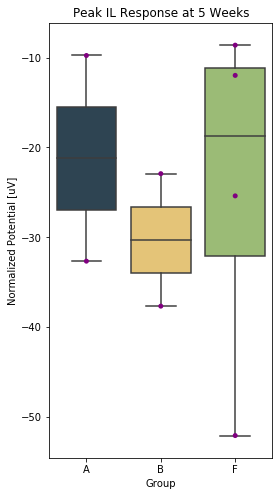

In [55]:
groupdict = {'A' : '#2e4452', 'B' : '#e4c478', 'F' : '#9bbb76'}
groups = ['A', 'B', 'F']
plt.rcParams['figure.figsize'] = (4, 8)
masterframe = masterframe.sort_values(by=['group'])
ax = sns.boxplot(x="group", y="best_this_day_left_IL_min", data=masterframe.loc[masterframe['recording_session'] == 'Day 2'])
ax = sns.swarmplot(x="group", y="best_this_day_left_IL_min", data=masterframe.loc[masterframe['recording_session'] == 'Day 2'], color='purple')
for i in range(len(list(masterframe.loc[masterframe['recording_session'] == 'Day 2']['group'].unique()))):
    mybox = ax.artists[i]
    mybox.set_facecolor(groupdict[groups[i]])
ax.set_title('Peak IL Response at 5 Weeks')
ax.set_ylabel('Normalized Potential [uV]', fontsize=10)
ax.set_xlabel('Group', fontsize=10)
plt.savefig(join(join(base_dir, 'out'), "Group_means.pdf"), format='pdf', bbox_inches='tight', transparent=True)

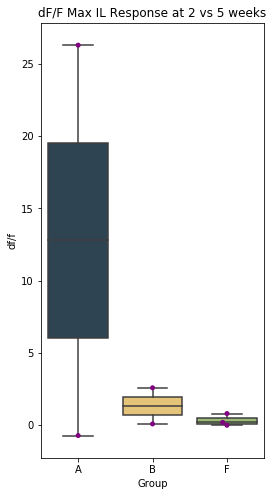

In [56]:
cross_day_masterframe = cross_day_masterframe.sort_values(by=['group'])
ax2 = sns.boxplot(x="group", y="df/f_12_left", data=cross_day_masterframe)
ax2 = sns.swarmplot(x="group", y="df/f_12_left", data=cross_day_masterframe, color="purple")
for i in range(len(list(cross_day_masterframe['group'].unique()))):
    mybox = ax2.artists[i]
    mybox.set_facecolor(groupdict[groups[i]])
ax2.set_title('dF/F Max IL Response at 2 vs 5 weeks')
ax2.set_ylabel('df/f', fontsize=10)
ax2.set_xlabel('Group', fontsize=10)
plt.savefig(join(join(base_dir, 'out'), "Group_df_f.pdf"), format='pdf', bbox_inches='tight', transparent=True)

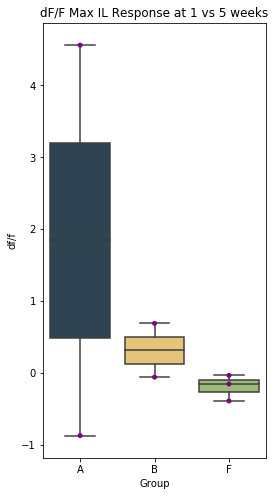

In [57]:
cross_day_masterframe = cross_day_masterframe.sort_values(by=['group'])
ax2 = sns.boxplot(x="group", y="df/f_02_left", data=cross_day_masterframe)
ax2 = sns.swarmplot(x="group", y="df/f_02_left", data=cross_day_masterframe, color="purple")
for i in range(len(list(cross_day_masterframe['group'].unique()))):
    mybox = ax2.artists[i]
    mybox.set_facecolor(groupdict[groups[i]])
ax2.set_title('dF/F Max IL Response at 1 vs 5 weeks')
ax2.set_ylabel('df/f', fontsize=10)
ax2.set_xlabel('Group', fontsize=10)
plt.savefig(join(join(base_dir, 'out'), "Group_df_f.pdf"), format='pdf', bbox_inches='tight', transparent=True)

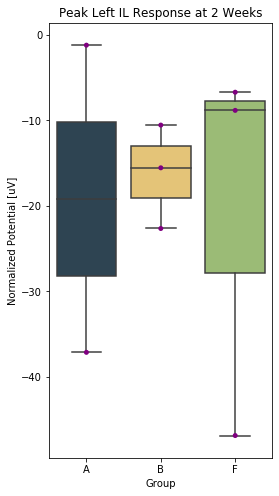

In [58]:
ax2 = sns.boxplot(x="group", y="best_this_day_left_IL_min", data=masterframe.loc[masterframe['recording_session'] == 'Day 1'])
ax2 = sns.swarmplot(x="group", y="best_this_day_left_IL_min", data=masterframe.loc[masterframe['recording_session'] == 'Day 1'], color="purple")
for i in range(len(list(masterframe.loc[masterframe['recording_session'] == 'Day 1']['group'].unique()))):
    mybox = ax2.artists[i]
    mybox.set_facecolor(groupdict[groups[i]])
ax2.set_title('Peak Left IL Response at 2 Weeks')
ax2.set_ylabel('Normalized Potential [uV]', fontsize=10)
ax2.set_xlabel('Group', fontsize=10)
plt.savefig(join(join(base_dir, 'out'), "Day 1 Distribution.pdf"), format='pdf', bbox_inches='tight', transparent=True)

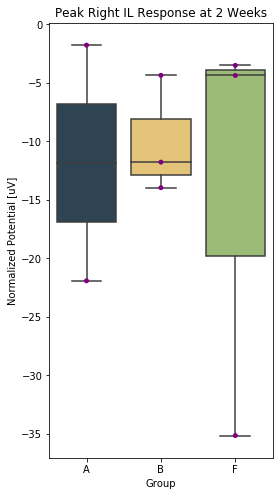

In [59]:
ax2 = sns.boxplot(x="group", y="best_this_day_right_IL_min", data=masterframe.loc[masterframe['recording_session'] == 'Day 1'])
ax2 = sns.swarmplot(x="group", y="best_this_day_right_IL_min", data=masterframe.loc[masterframe['recording_session'] == 'Day 1'], color="purple")
for i in range(len(list(masterframe.loc[masterframe['recording_session'] == 'Day 1']['group'].unique()))):
    mybox = ax2.artists[i]
    mybox.set_facecolor(groupdict[groups[i]])
ax2.set_title('Peak Right IL Response at 2 Weeks')
ax2.set_ylabel('Normalized Potential [uV]', fontsize=10)
ax2.set_xlabel('Group', fontsize=10)
plt.savefig(join(join(base_dir, 'out'), "Day 1 Distribution Right.pdf"), format='pdf', bbox_inches='tight', transparent=True)

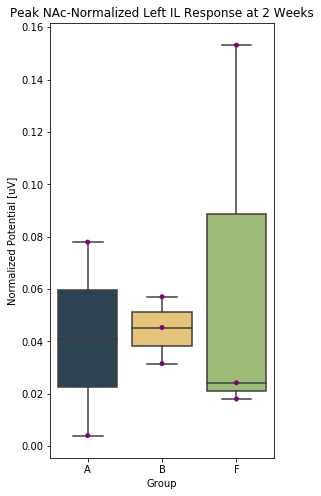

In [60]:
ax2 = sns.boxplot(x="group", y="best_this_day_left_min_IL_NAc_normalized", data=masterframe.loc[masterframe['recording_session'] == 'Day 1'])
ax2 = sns.swarmplot(x="group", y="best_this_day_left_min_IL_NAc_normalized", data=masterframe.loc[masterframe['recording_session'] == 'Day 1'], color="purple")
for i in range(len(list(masterframe.loc[masterframe['recording_session'] == 'Day 1']['group'].unique()))):
    mybox = ax2.artists[i]
    mybox.set_facecolor(groupdict[groups[i]])
ax2.set_title('Peak NAc-Normalized Left IL Response at 2 Weeks')
ax2.set_ylabel('Normalized Potential [uV]', fontsize=10)
ax2.set_xlabel('Group', fontsize=10)
plt.savefig(join(join(base_dir, 'out'), "Day 1 Distribution Normalized.pdf"), format='pdf', bbox_inches='tight', transparent=True)

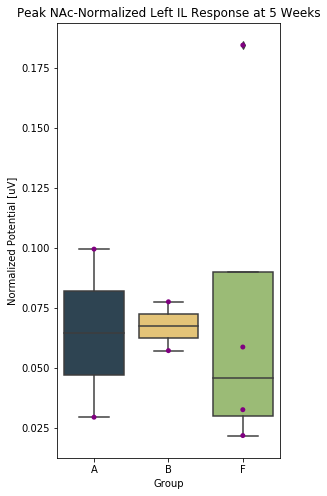

In [61]:
ax2 = sns.boxplot(x="group", y="best_this_day_left_min_IL_NAc_normalized", data=masterframe.loc[masterframe['recording_session'] == 'Day 2'])
ax2 = sns.swarmplot(x="group", y="best_this_day_left_min_IL_NAc_normalized", data=masterframe.loc[masterframe['recording_session'] == 'Day 2'], color="purple")
for i in range(len(list(masterframe.loc[masterframe['recording_session'] == 'Day 2']['group'].unique()))):
    mybox = ax2.artists[i]
    mybox.set_facecolor(groupdict[groups[i]])
ax2.set_title('Peak NAc-Normalized Left IL Response at 5 Weeks')
ax2.set_ylabel('Normalized Potential [uV]', fontsize=10)
ax2.set_xlabel('Group', fontsize=10)
plt.savefig(join(join(base_dir, 'out'), "Day 2 Distribution Normalized.pdf"), format='pdf', bbox_inches='tight', transparent=True)

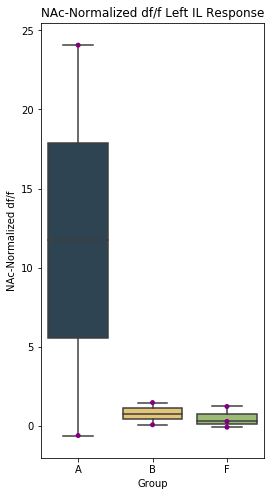

In [62]:
ax2 = sns.boxplot(x="group", y="NAc_normalized_df/f_12_left", data=cross_day_masterframe)
ax2 = sns.swarmplot(x="group", y="NAc_normalized_df/f_12_left", data=cross_day_masterframe, color="purple")
for i in range(len(list(cross_day_masterframe['group'].unique()))):
    mybox = ax2.artists[i]
    mybox.set_facecolor(groupdict[groups[i]])
ax2.set_title('NAc-Normalized df/f Left IL Response')
ax2.set_ylabel('NAc-Normalized df/f', fontsize=10)
ax2.set_xlabel('Group', fontsize=10)
plt.savefig(join(join(base_dir, 'out'), "Dff Distribution Normalized.pdf"), format='pdf', bbox_inches='tight', transparent=True)

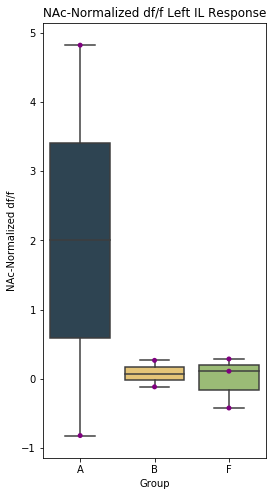

In [63]:
ax2 = sns.boxplot(x="group", y="NAc_normalized_df/f_02_left", data=cross_day_masterframe)
ax2 = sns.swarmplot(x="group", y="NAc_normalized_df/f_02_left", data=cross_day_masterframe, color="purple")
for i in range(len(list(cross_day_masterframe['group'].unique()))):
    mybox = ax2.artists[i]
    mybox.set_facecolor(groupdict[groups[i]])
ax2.set_title('NAc-Normalized df/f Left IL Response')
ax2.set_ylabel('NAc-Normalized df/f', fontsize=10)
ax2.set_xlabel('Group', fontsize=10)
plt.savefig(join(join(base_dir, 'out'), "Dff Distribution Normalized d02.pdf"), format='pdf', bbox_inches='tight', transparent=True)

In [131]:
masterframe = masterframe.sort_values(by=['group', 'recording_session', 'mouseid'])
groupA = []
groupB = []
groupF = []
seen = []
for r in masterframe[['mouseid', 'group']].iterrows():
    mid = r[1]['mouseid']
    group = r[1]['group']
    if mid not in seen:
        seen.append(mid)
        if group == 'A':
            groupA.append(mid)
        elif group == 'B':
            groupB.append(mid)
        else:
            groupF.append(mid)

# Wanted palette details
enmax_palette = ["#2e4452", "#e4c478", "#9bbb76"]
color_codes_wanted = ['blue', 'yellow', 'green']

groupA_palette = sns.color_palette('light:#2e4452', len(groupA)).as_hex()
groupB_palette = sns.color_palette('light:#e4c478', len(groupB)).as_hex()
groupF_palette = sns.color_palette('light:#9bbb76', len(groupF)).as_hex()

colormap = {}
seen = []
a_count = 0
b_count = 0
f_count = 0
for r in masterframe[['mouseid', 'group']].iterrows():
    mid = r[1]['mouseid']
    group = r[1]['group']
    if mid not in seen:
        seen.append(mid)
        if group == 'A':
            colormap[mid] = groupA_palette[a_count]
            a_count += 1
        elif group == 'B':
            colormap[mid] = groupB_palette[b_count]
            b_count += 1
        else:
            colormap[mid] = groupF_palette[f_count]
            f_count += 1

ax2 = sns.lineplot(x="recording_session", y="best_this_day_NAc_min", hue='mouseid', palette=colormap, data=masterframe)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax2.set_title('Highest NAc response by Day')
ax2.set_ylabel('NAc Response [µV]', fontsize=10)
ax2.set_xlabel('Day', fontsize=10)
plt.savefig(join(join(base_dir, 'out'), "mice_nac2.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.clf()
plt.cla()
plt.close('all')

ax3 = sns.lineplot(x="recording_session", y="best_this_day_left_IL_min", hue='mouseid', palette=colormap, data=masterframe)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax3.set_title('Highest IL response by Day')
ax3.set_ylabel('IL Response [µV]', fontsize=10)
ax3.set_xlabel('Day', fontsize=10)
plt.savefig(join(join(base_dir, 'out'), "mice_IL2.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.clf()
plt.cla()
plt.close('all')


In [139]:
import pingouin as pg
cleaned = masterframe.copy()
for mouseid in cleaned['mouseid'].unique():
    if cleaned.loc[cleaned['mouseid'] == mouseid].shape[0] != 3:
        cleaned = cleaned.loc[cleaned['mouseid'] != mouseid]

pg.rm_anova(dv='best_this_day_left_IL_min', within=['group', 'recording_session'], subject='mouseid', data=cleaned)


/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:8525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:459: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 le

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,group,2314.068799,2,36,1157.034400,-1.292986,1.000000,NaN,-0.077392,NaN
1,recording_session,4313.391942,2,36,2156.695971,2.208327,0.124554,0.151565,0.109278,0.556184
2,group * recording_session,3511.759052,4,72,877.939763,-2.119331,1.000000,NaN,-0.133454,NaN


In [141]:
cleaned.loc[cleaned['best_this_day_left_IL_min'] < -80]

,mouseid,date,group,recording_session,functional_chans,best_this_day_left_IL_wire_id,best_this_day_right_IL_wire_id,best_this_day_NAc_wire_id,best_this_day_left_IL_min,best_this_day_left_IL_max,best_this_day_right_IL_min,best_this_day_right_IL_max,best_this_day_NAc_min,best_this_day_left_min_IL_NAc_normalized,best_this_day_right_min_IL_NAc_normalized,best_this_day_left_max_IL_NAc_normalized,best_this_day_right_max_IL_NAc_normalized
0,04093,070622,B,Day 2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",2,7,9,-114.736260,-5.150094,-19.618842,1.204880,-426.656260,0.26892,0.045983,0.012071,-0.002824
0,04125,070822,F,Day 2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",2,7,8,-84.883437,-1.564394,-188.926364,-3.565333,-302.334275,0.28076,0.624892,0.005174,0.011793


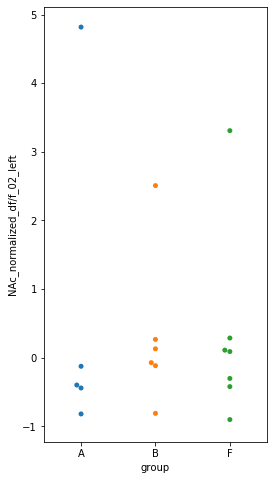

In [96]:
cross_day_masterframe = cross_day_masterframe.sort_values(by=['group'])
ax2 = sns.lineplot(x="recording_session", y="NAc_normalized_df/f_02_left", data=cross_day_masterframe.loc[~cross_day_masterframe["NAc_normalized_df/f_02_left"].isnull()])
plt.savefig(join(join(base_dir, 'out'), "pre_histo_ruleout.pdf"), format='pdf', bbox_inches='tight', transparent=True)

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Could not interpret value `best_this_day_left_IL_min` for parameter `y`

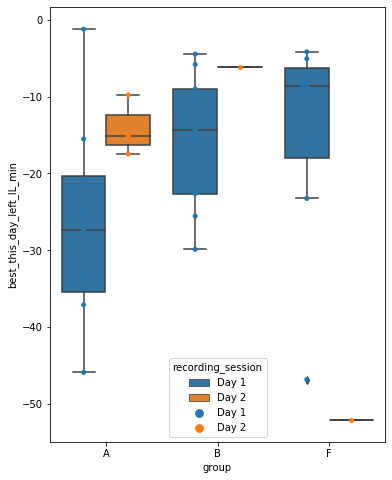

In [40]:
plt.rcParams['figure.figsize'] = (6, 8)
ax2 = sns.boxplot(x="group", y="best_this_day_left_IL_min", hue = 'recording_session', data=masterframe)
ax2 = sns.swarmplot(x="group", y="best_this_day_left_IL_min", hue = 'recording_session', data=masterframe, dodge=True)
# for i in range(len(list(masterframe.loc[masterframe['recording_session'] == 'Day 1']['group'].unique()))):
#     mybox = ax2.artists[i]
#     mybox.set_facecolor(groupdict[groups[i]])
sns.lineplot(masterframe, x="group", y="best_this_day_left_IL_min", hue="recording_session", units = "mouseid", color=".7", estimator=None, ax=ax2)
ax2.set_title('Peak IL Response Comparison at 2 and 5 Weeks')
ax2.set_ylabel('Normalized Potential [uV]', fontsize=10)
ax2.set_xlabel('Group', fontsize=10)
plt.savefig(join(join(base_dir, 'out'), "IL Response Comparison at 2 and 5 Weeks.pdf"), format='pdf', bbox_inches='tight', transparent=True)

In [95]:
str(element[recording_session]).strip('.0')

NameError: name 'recording_session' is not defined

In [82]:
usability_df = pd.read_csv(disambig_url)
for element in usability_df.iterrows():
    print(element[1]['Mouse'])
    break

55411


In [135]:
# data.delete_date('55441', '040722')
# data.save()
data.show_mice()

Here is what we got:
Mouse10421
	 040622 Usable


Mouse10422
	 040622 Not usable
	 040722 Usable


Mouse10424
	 040622 Usable


Mouse10425
	 040622 Usable


Mouse10441
	 040622 Not usable
	 040722 Usable


Mouse10443
	 040722 Usable


Mouse10444
	 040622 Usable


Mouse55411
	 030922 Not usable


Mouse55412
	 030922 Usable
	 033022 Not usable
	 040722 Usable


Mouse55413
	 030922 Not usable
	 033022 Usable
	 040722 Usable


Mouse55414
	 030922 Not usable
	 033022 Not usable
	 040722 Usable


Mouse55415
	 030922 Not usable
	 033022 Usable
	 040722 Usable


Mouse55422
	 031122 Not usable
	 040122 Not usable
	 040722 Usable


Mouse55423
	 031122 Not usable
	 040122 Not usable
	 040722 Usable


Mouse55425
	 031122 Not usable
	 040122 Not usable
	 040722 Usable


Mouse55431
	 032122 Usable
	 040422 Not usable
	 040722 Usable


Mouse55432
	 032122 Usable
	 040422 Usable


Mouse55433
	 032122 Not usable
	 040722 Usable


Mouse55434
	 032122 Not usable
	 040722 Usable


Mouse55435
	 032122 Not 

In [49]:
mouseid = '55431'
date = '040422'
excluded = []
if mouseid in excluded_channels.keys():
    if date in excluded_channels[mouseid].keys():
        excluded = excluded_channels[mouseid][date]
w = range(0, 8)
w = [True if x in w and x not in excluded else False for x in range(12)]
#0: channel, 1: stimulus, 2: time points
normalized_all_plotted = data.get_stimcalc(mouseid, date)
means = []
stds = []
print(normalized_all_plotted.shape)
normalized_all_plotted[w, :, :].shape
# for i in range(normalized_all_plotted.shape[2]):
#     means.append(np.mean(np.take(normalized_all_plotted, w, axis = 0)[:, : i]))
#     stds.append(np.std(np.take(normalized_all_plotted, w, axis = 0)[:, : i]))
#     break


(12, 30, 615)


(7, 30, 615)

In [14]:
data.show_mice()

Here is what we got:
Mouse55411
	 030922


Mouse55412
	 030922
	 033022


Mouse55413
	 030922
	 033022


Mouse55414
	 030922
	 033022


Mouse55415
	 030922
	 033022


Mouse55422
	 031122


Mouse55423
	 031122


Mouse55425
	 031122


Mouse55425.2
	 040122


Mouse55431
	 032122
	 040422


Mouse55432
	 032122


Mouse55433
	 032122


Mouse55434
	 032122


Mouse55435
	 032122




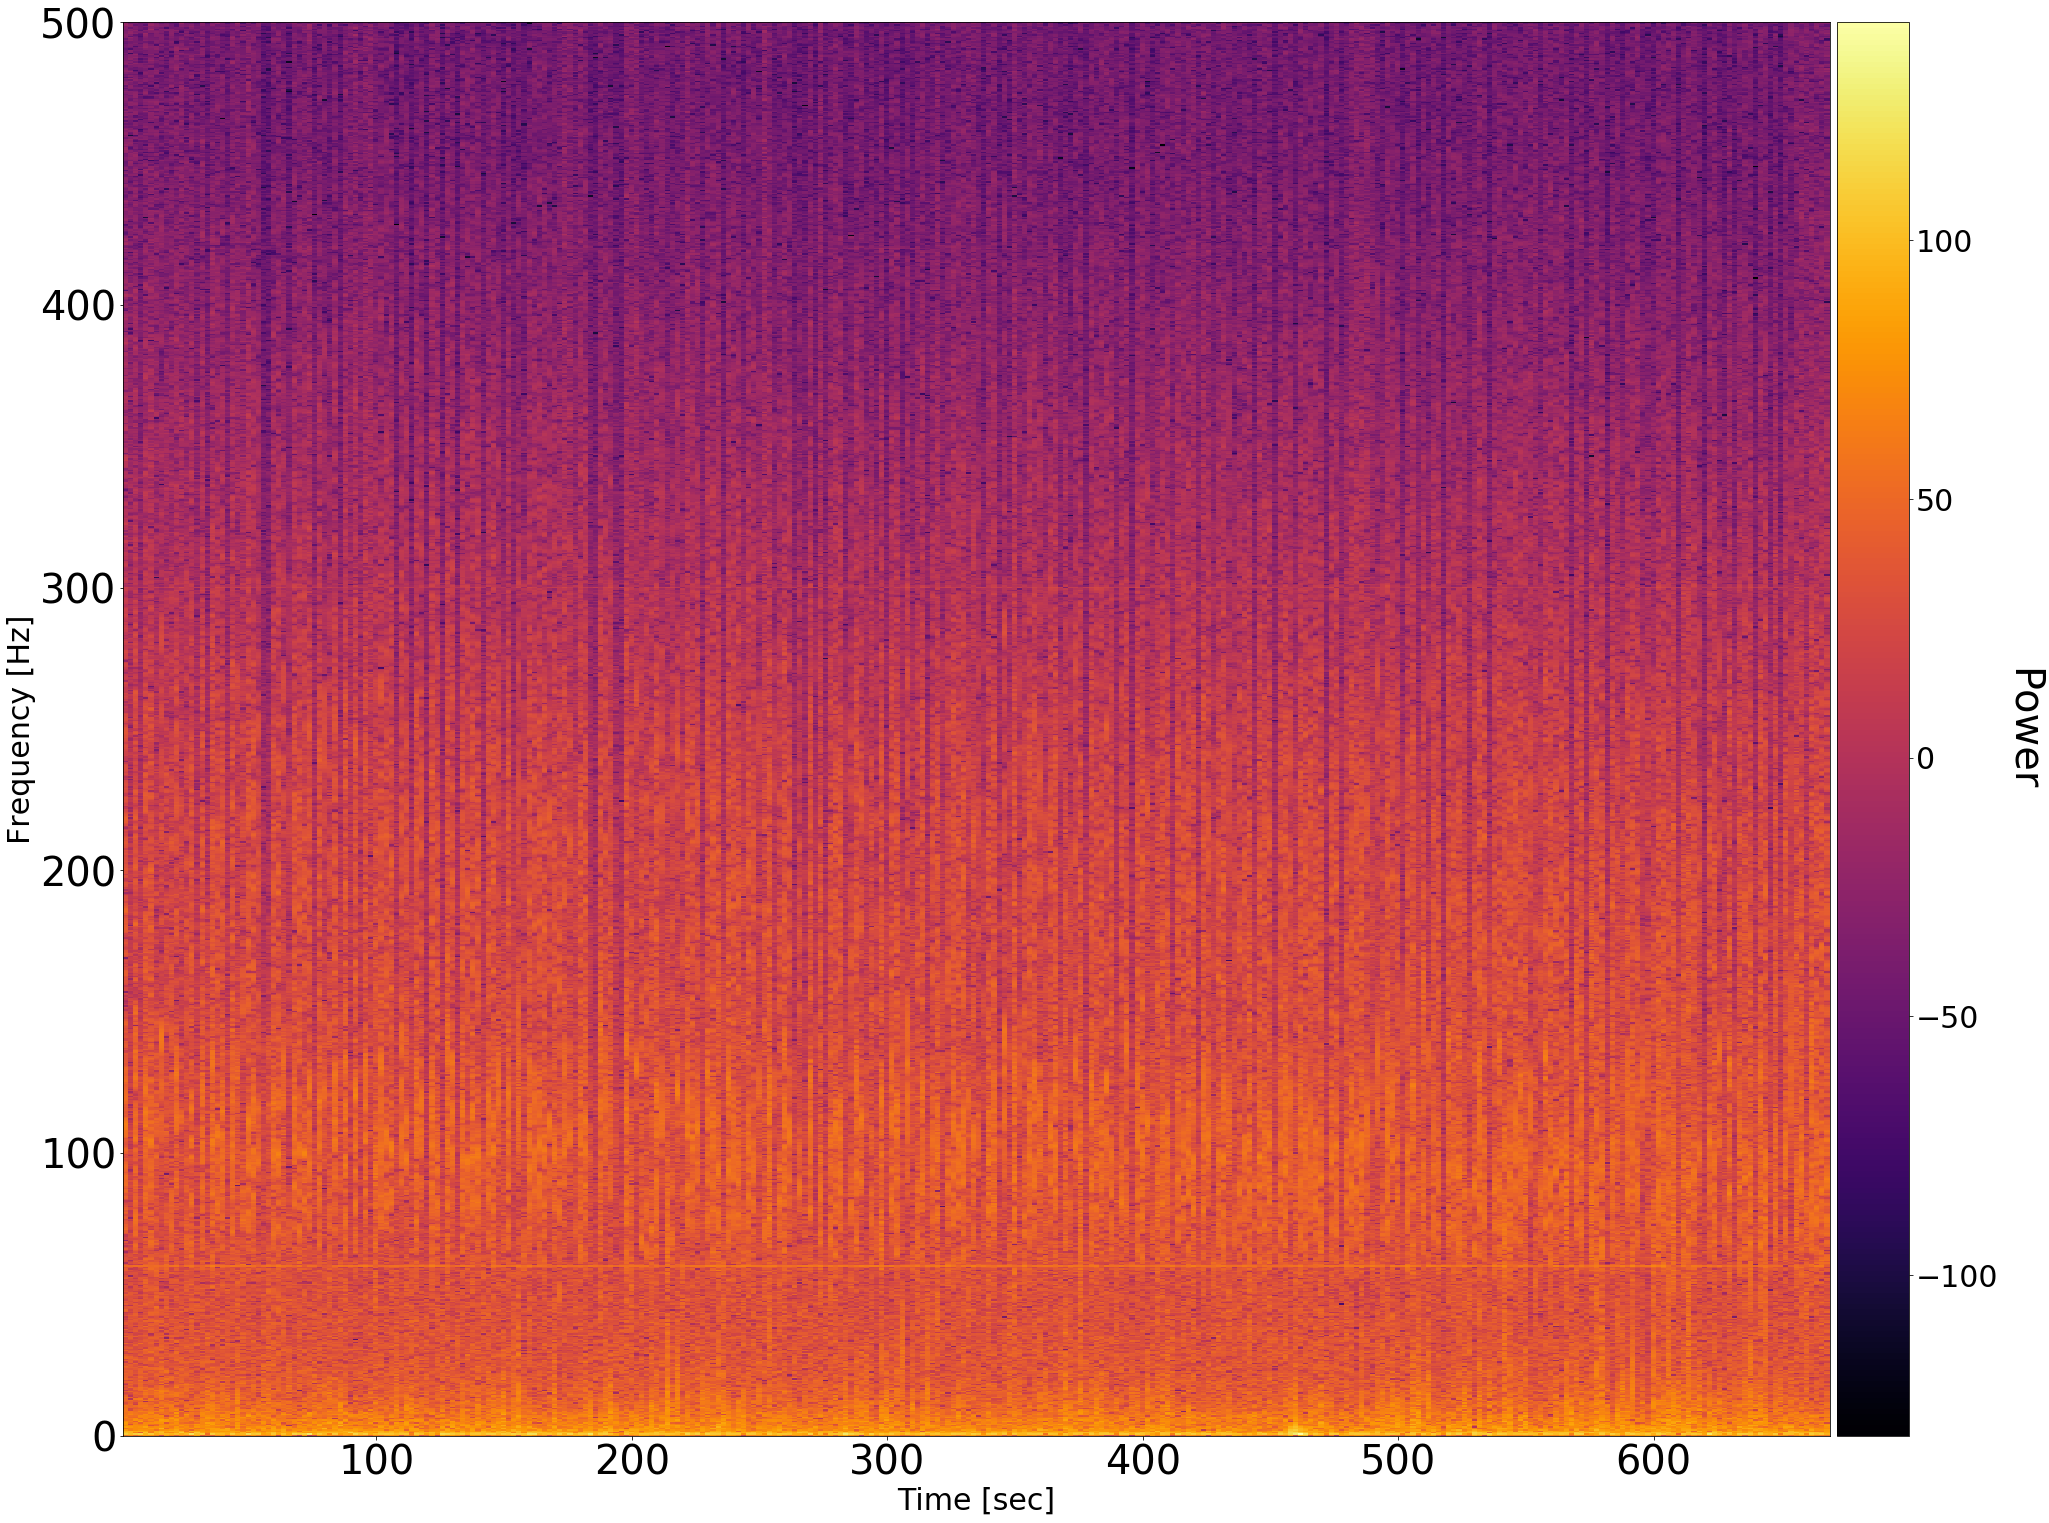

In [16]:
outfolder = '/Users/kirill/Desktop/lab/OptoLinCx/out'
freq_res = 0.125 #in Hz
time_res = 0.5 #in s
# sf = data.samplingFrequency
sf = 1000
dat = datum
# dat = data.get_chan('55411', '030922', 8)
b, a = signal.butter(1, 0.5/(sf/2), 'high', analog=True)
y = signal.filtfilt(b, a, dat, padlen=150)
f, t, Sxx = signal.spectrogram(y, fs=sf, nperseg = sf*2, noverlap=0)
pxx = abs(Sxx)
PowerdB = 20*np.log10(pxx)
plt.rcParams['figure.figsize'] = (32, 26)
plt.pcolormesh(t, f, PowerdB, cmap='inferno')
plt.ylabel('Frequency [Hz]', fontsize=30)
plt.xlabel('Time [sec]', fontsize=30)
ax = plt.gca()
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=1., pad=0.1)
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Power', rotation=-90, va="bottom", fontsize=40)
cbar.ax.tick_params(labelsize=30)
plt.savefig(join(outfolder, "Spectogram.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.show()

In [16]:
filedir = '/Users/kirill/Desktop/lab/OptoLinCx/Mouse04094/061422/Mouse04094_061422_OptoLinCx'
reader = BlackrockRawIO(filename=filedir, nsx_to_load = 2)
reader.parse_header()
raw_sigs = np.array(reader.get_analogsignal_chunk(channel_indexes=None))/4
datum = raw_sigs[:, 2]
plt.plot(datum)

ValueError: Size of available data is not a multiple of the data-type size.

In [14]:
from scipy.io.wavfile import write
m = np.max(np.abs(datum))
sigf32 = (datum/m).astype(np.float32)
write('test.wav', 1000, sigf32)

In [11]:
from scipy.io.wavfile import write
samplerate = 44100; fs = 100
t = np.linspace(0., 1., samplerate)
amplitude = np.iinfo(np.int16).max
data = amplitude * np.sin(2. * np.pi * fs * t)
write("example.wav", samplerate, data.astype(np.int16))

In [19]:
laser_threshold = laser.copy()
laser_threshold[laser_threshold <= 500] = 0
laser_threshold[laser_threshold > 0] = 1
ld = []
prev_val = 0
start_stim = None
stop_stim = None
for i, val in enumerate(laser_threshold):
    if val == 1 and prev_val == 0:
        start_stim = i
        prev_val = 1
    elif val == 0 and prev_val == 1:
        stop_stim = i
        prev_val = 0
        ld.append([start_stim, stop_stim])
print([(pair[1] - pair[0])/1000 for pair in ld])

[0.012, 0.012, 0.012, 0.012, 0.011, 0.012, 0.012, 0.011, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.011, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012]


In [88]:
max(laser)

15928

In [28]:
w = list(range(0, 7))
excluded = [3]
w = [x for x in w if x not in excluded]
w

[0, 1, 2, 4, 5, 6]

In [7]:
def stim_wire_vector(data, mouseid, date, chanid):
    normalized_all_plotted = data.get_stimcalc(mouseid, date)
    means = []
    stds = []
    #0: channel, 1: stimulus, 2: time points
    for i in range(normalized_all_plotted.shape[2]):
        means.append(np.mean(normalized_all_plotted[chanid, :, i]))
        stds.append(np.std(normalized_all_plotted[chanid, :, i]))
    return [means, stds]

In [31]:
A = stim_wire_vector(data, '55413', '033022', 0)[0][:300]
A = A - np.mean(A)  # remove the DC part of the signal
C = np.correlate(A, A, 'same')  # calculate autocorrelation to smooth out the noise
P = signal.argrelextrema(C, np.greater)[0]  # caluclate local maxima (this step can be improved)
P = P[C[P]>15000] # filter maxima, where the autocorrelation values is too low
mean_resp = np.mean(np.array([np.abs(A[pos]) for pos in P]))
mean_resp


155.24381652661066

5.619549310710501

In [33]:
for i in range(13):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12


In [38]:
def find_good_bad_channels(data, mouseid, date):
    channel_assignments = {i : True for i in range(12)}
    for chanid in range(12):
        #First, look at the noise in the signal: if pre-stimulus dominant frequency has peaks on average larger than 10, 
        #the channel is bad; alternatively, if signal portion has the lowest point not within 100 of -500uV,
        #it is also considered bad
        swv = data.stim_wire_vector(mouseid, date, chanid)[0]
        A = swv[:300] #get first 300 ms of signal, i.e. before stim
        A = A - np.mean(A)  # remove the DC part of the signal
        C = np.correlate(A, A, 'same')  # calculate autocorrelation to smooth out the noise
        P = signal.argrelextrema(C, np.greater)[0]  # caluclate local maxima (this step can be improved)
        P = P[C[P]>15000] # filter maxima, where the autocorrelation values is too low
        mean_resp = np.mean(np.array([np.abs(A[pos]) for pos in P]))
        if mean_resp > 12 or (chanid > 7 and (min(swv) > -400 or min(swv) < -600)):
            if chanid > 7 and mean_resp > 10:
                print('bad')
                print(mean_resp)
            channel_assignments[chanid] = False
    return channel_assignments

In [42]:
find_good_bad_channels(data, '55422', '040722')

bad
21.39616666666667
bad
21.025916666666667
bad
20.72027777777778
bad
20.96147222222222


{0: False,
 1: False,
 2: False,
 3: False,
 4: False,
 5: False,
 6: False,
 7: False,
 8: False,
 9: False,
 10: False,
 11: False}